# LIME Explainability on Heart-Shaped Dataset

Compare LIME feature importance from **SVM-RBF** and a **PyTorch neural network** on a non-convex heart-shaped 2D classification problem.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
from lime.lime_tabular import LimeTabularExplainer
import os
import warnings
warnings.filterwarnings('ignore')

## 1. Generate Heart-Shaped Dataset

The heart boundary is defined by the implicit equation $(x^2 + y^2 - 1)^3 - x^2 y^3 < 0$.
Points inside are class +1 (red), outside are class -1 (blue).

In [2]:
def is_inside_heart(x, y):
    """Check if (x, y) is inside the heart curve (centered at origin, radius ~1)."""
    return (x**2 + y**2 - 1)**3 - x**2 * y**3 < 0

np.random.seed(42)

# Sample points in [-1.5, 1.5] x [-1.5, 1.8] and classify by heart boundary
n_samples = 2000
raw_x = np.random.uniform(-1.5, 1.5, n_samples)
raw_y = np.random.uniform(-1.5, 1.8, n_samples)
labels = np.array([1.0 if is_inside_heart(rx, ry) else -1.0 for rx, ry in zip(raw_x, raw_y)])

# Balance classes: take equal counts of inside/outside
inside_mask = labels == 1.0
outside_mask = labels == -1.0
n_min = min(inside_mask.sum(), outside_mask.sum(), 500)

inside_idx = np.where(inside_mask)[0][:n_min]
outside_idx = np.where(outside_mask)[0][:n_min]
keep_idx = np.concatenate([inside_idx, outside_idx])
np.random.shuffle(keep_idx)

# Normalize to [0, 1] range
raw_pts = np.column_stack([raw_x[keep_idx], raw_y[keep_idx]])
X = (raw_pts - raw_pts.min(axis=0)) / (raw_pts.max(axis=0) - raw_pts.min(axis=0))
y = labels[keep_idx]

# Save dataset
save_path = os.path.join('..', 'datasets', 'dataset_heart.npz')
np.savez(save_path, X=X, y=y)

print(f"Dataset: {X.shape[0]} points")
print(f"  Inside heart (red, +1):  {int((y == 1).sum())}")
print(f"  Outside heart (blue, -1): {int((y == -1).sum())}")
print(f"  Saved to: {save_path}")

Dataset: 1000 points
  Inside heart (red, +1):  500
  Outside heart (blue, -1): 500
  Saved to: ..\datasets\dataset_heart.npz


## 2. Visualize Dataset

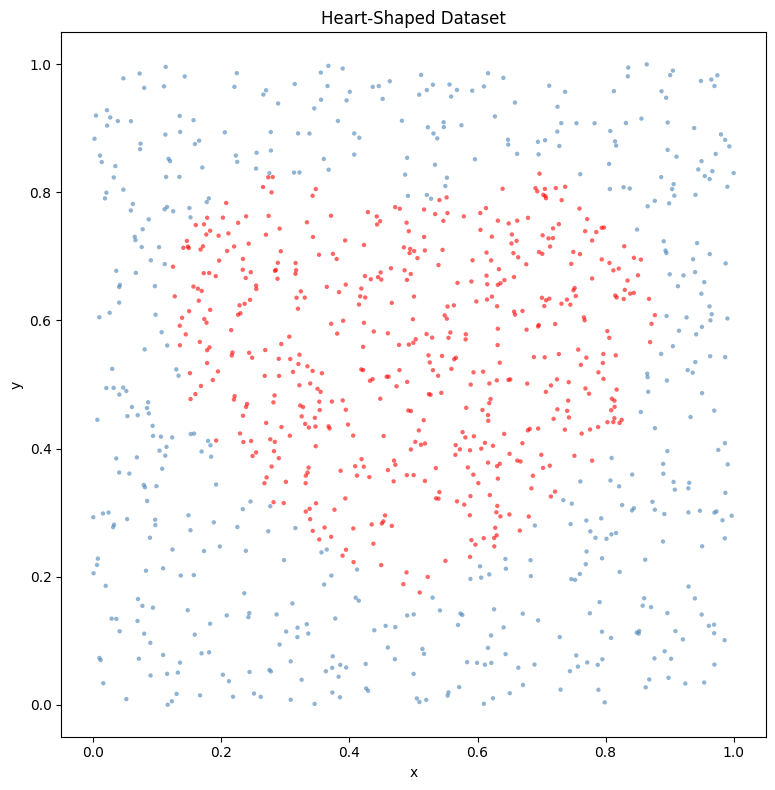

In [3]:
fig, ax = plt.subplots(figsize=(8, 8))
colors = ['red' if label == 1 else 'steelblue' for label in y]
ax.scatter(X[:, 0], X[:, 1], c=colors, s=10, alpha=0.6, edgecolors='none')
ax.set_title('Heart-Shaped Dataset')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

## 3. Train/Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train: {X_train.shape[0]}  |  Test: {X_test.shape[0]}")

Train: 800  |  Test: 200


## 4. Train SVM-RBF

In [5]:
svm_model = SVC(kernel='rbf', C=100, gamma='scale', probability=True)
svm_model.fit(X_train, y_train)

svm_acc = accuracy_score(y_test, svm_model.predict(X_test))
print(f"SVM-RBF test accuracy: {svm_acc:.2%}")

SVM-RBF test accuracy: 97.50%


## 5. Train PyTorch Neural Network

In [6]:
# Labels in {0, 1} for binary cross-entropy
y_train_bin = ((y_train + 1) / 2).astype(np.float32)
y_test_bin = ((y_test + 1) / 2).astype(np.float32)

class HeartNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 1), nn.Sigmoid(),
        )
    def forward(self, x):
        return self.net(x)

nn_model = HeartNet()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

X_tr_t = torch.tensor(X_train, dtype=torch.float32)
y_tr_t = torch.tensor(y_train_bin, dtype=torch.float32).unsqueeze(1)

for epoch in range(200):
    optimizer.zero_grad()
    loss = loss_fn(nn_model(X_tr_t), y_tr_t)
    loss.backward()
    optimizer.step()

nn_model.eval()
with torch.no_grad():
    preds = nn_model(torch.tensor(X_test, dtype=torch.float32)).numpy().flatten()
nn_acc = ((preds.round()) == y_test_bin).mean()
print(f"PyTorch NN test accuracy: {nn_acc:.2%}")

def nn_predict_proba(X_input):
    """Wrapper to give LIME a predict_proba-style [P(class -1), P(class +1)] output."""
    nn_model.eval()
    with torch.no_grad():
        p = nn_model(torch.tensor(X_input, dtype=torch.float32)).numpy().flatten()
    return np.column_stack([1 - p, p])

PyTorch NN test accuracy: 96.50%


## 6. Visualize Decision Boundaries

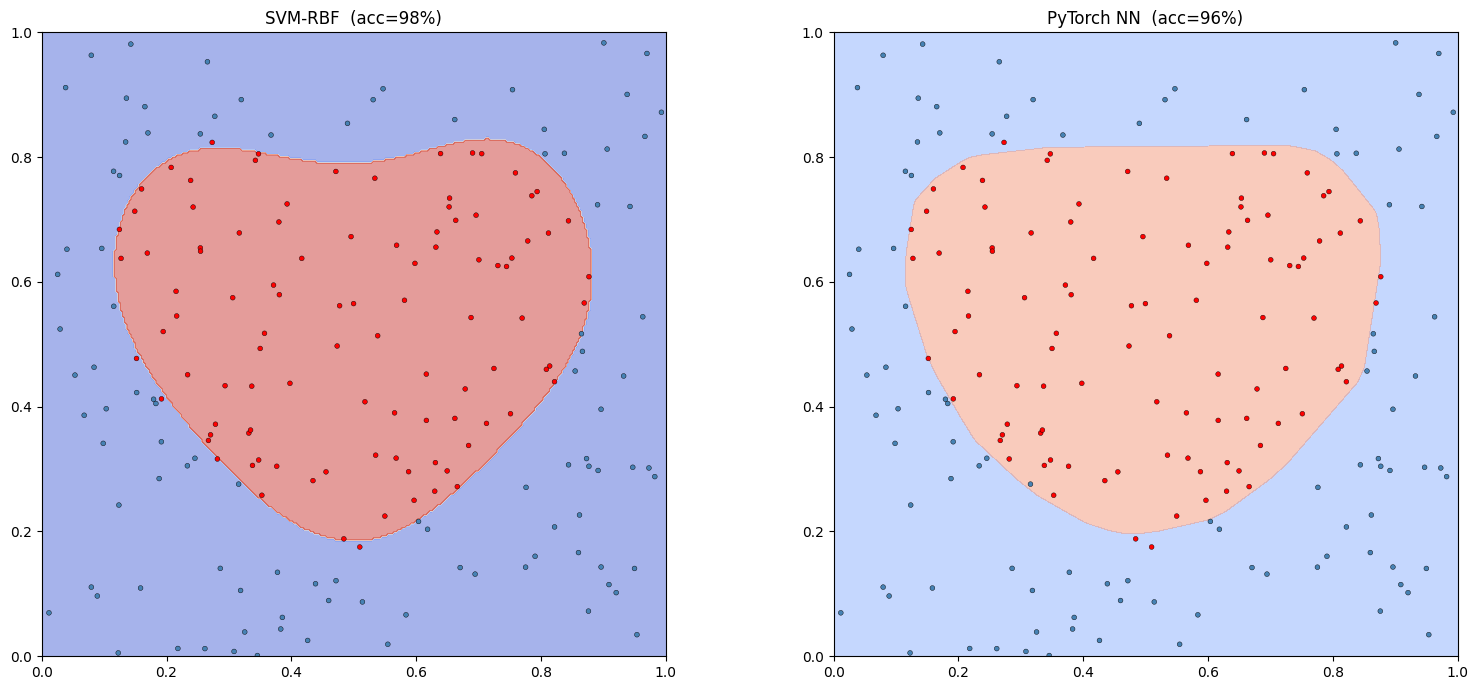

In [7]:
xx, yy = np.meshgrid(np.linspace(0, 1, 300), np.linspace(0, 1, 300))
grid = np.column_stack([xx.ravel(), yy.ravel()])

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# SVM decision boundary
Z_svm = svm_model.predict(grid).reshape(xx.shape)
axes[0].contourf(xx, yy, Z_svm, cmap=plt.cm.coolwarm, alpha=0.5)
axes[0].scatter(X_test[:, 0], X_test[:, 1],
                c=['red' if l == 1 else 'steelblue' for l in y_test],
                s=12, edgecolors='k', linewidths=0.3)
axes[0].set_title(f'SVM-RBF  (acc={svm_acc:.0%})')
axes[0].set_aspect('equal')

# NN decision boundary
with torch.no_grad():
    Z_nn = nn_model(torch.tensor(grid, dtype=torch.float32)).numpy().reshape(xx.shape)
axes[1].contourf(xx, yy, Z_nn, levels=[0, 0.5, 1], cmap=plt.cm.coolwarm, alpha=0.5)
axes[1].scatter(X_test[:, 0], X_test[:, 1],
                c=['red' if l == 1 else 'steelblue' for l in y_test],
                s=12, edgecolors='k', linewidths=0.3)
axes[1].set_title(f'PyTorch NN  (acc={nn_acc:.0%})')
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

## 7. Choose a Test Point X

Pick a point near the heart boundary where the explanation is most interesting.

Selected test point: x=0.8651, y=0.5169
SVM prediction: -1
SVM probabilities: [0.5 0.5]


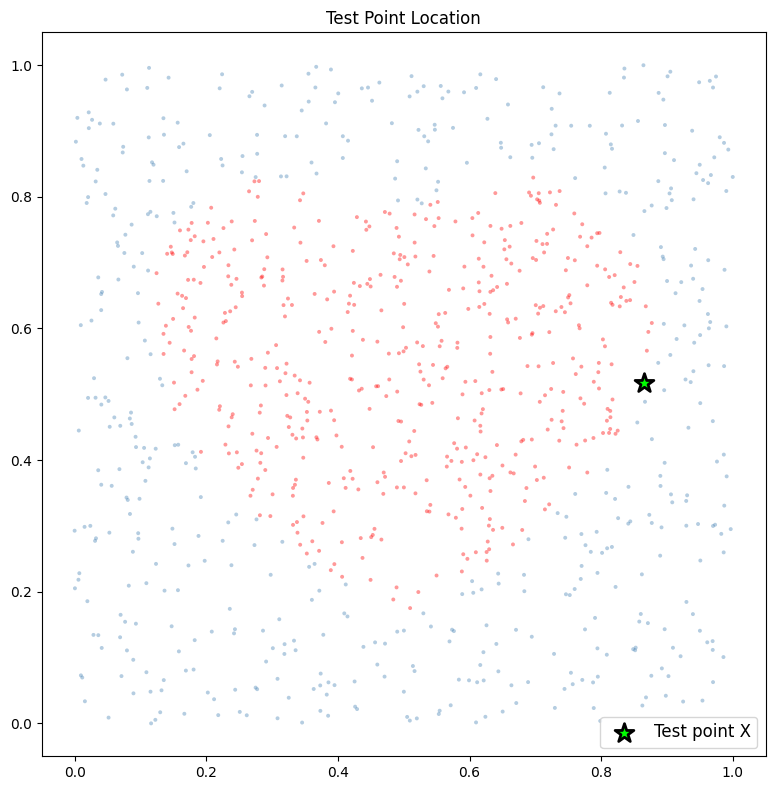

In [8]:
# Pick a point near the decision boundary from the test set
svm_proba = svm_model.predict_proba(X_test)
uncertainty = np.abs(svm_proba[:, 0] - svm_proba[:, 1])
boundary_idx = np.argmin(uncertainty)  # most uncertain = closest to boundary

x_test_point = X_test[boundary_idx]
print(f"Selected test point: x={x_test_point[0]:.4f}, y={x_test_point[1]:.4f}")
print(f"SVM prediction: {svm_model.predict(x_test_point.reshape(1, -1))[0]:.0f}")
print(f"SVM probabilities: {svm_proba[boundary_idx]}")

fig, ax = plt.subplots(figsize=(8, 8))
colors = ['red' if l == 1 else 'steelblue' for l in y]
ax.scatter(X[:, 0], X[:, 1], c=colors, s=8, alpha=0.4, edgecolors='none')
ax.scatter(x_test_point[0], x_test_point[1], c='lime', s=200, marker='*',
           edgecolors='black', linewidths=2, zorder=10, label='Test point X')
ax.legend(fontsize=12)
ax.set_title('Test Point Location')
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

## 8. LIME Explanation — SVM-RBF

In [9]:
explainer = LimeTabularExplainer(
    X_train,
    feature_names=['x', 'y'],
    class_names=['outside (-1)', 'inside (+1)'],
    mode='classification',
    random_state=42,
)

exp_svm = explainer.explain_instance(
    x_test_point,
    svm_model.predict_proba,
    num_features=2,
    num_samples=5000,
)

print("SVM-RBF LIME explanation:")
for feat, weight in exp_svm.as_list():
    print(f"  {feat}: {weight:+.4f}")

exp_svm.show_in_notebook(show_table=True)

SVM-RBF LIME explanation:
  x > 0.72: -0.2739
  0.32 < y <= 0.53: +0.2261


## 9. LIME Explanation — PyTorch NN

In [10]:
exp_nn = explainer.explain_instance(
    x_test_point,
    nn_predict_proba,
    num_features=2,
    num_samples=5000,
)

print("PyTorch NN LIME explanation:")
for feat, weight in exp_nn.as_list():
    print(f"  {feat}: {weight:+.4f}")

exp_nn.show_in_notebook(show_table=True)

PyTorch NN LIME explanation:
  x > 0.72: -0.2816
  0.32 < y <= 0.53: +0.2711


## 10. Compare LIME Importance Vectors

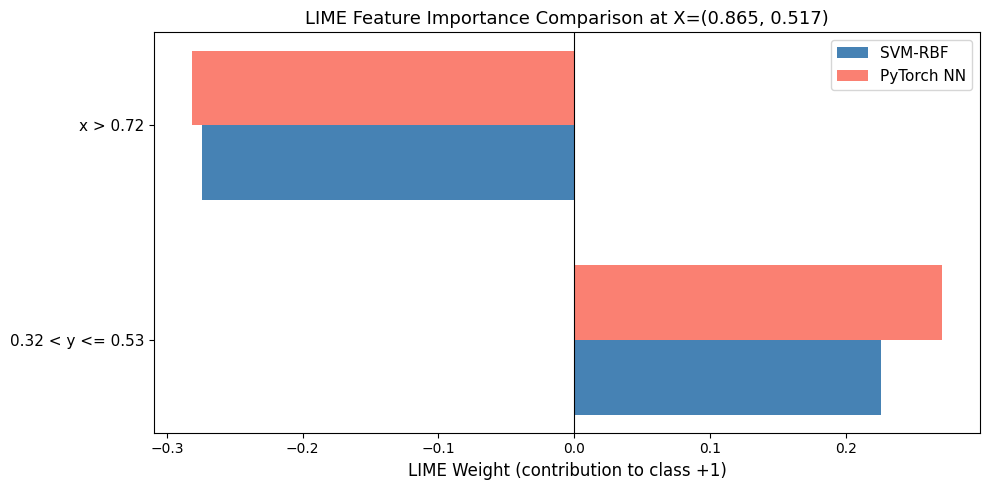


Importance vector (SVM-RBF): [0.22606517186979394, -0.2739003876471547]
Importance vector (Keras NN): [0.2710734671821161, -0.28164013533190957]


In [11]:
# Extract importance weights as dicts {feature_condition: weight}
svm_weights = dict(exp_svm.as_list())
nn_weights = dict(exp_nn.as_list())

# Align feature labels
all_features = sorted(set(list(svm_weights.keys()) + list(nn_weights.keys())))
svm_vals = [svm_weights.get(f, 0) for f in all_features]
nn_vals = [nn_weights.get(f, 0) for f in all_features]

fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.35
x_pos = np.arange(len(all_features))

ax.barh(x_pos - bar_width/2, svm_vals, bar_width, label='SVM-RBF', color='steelblue')
ax.barh(x_pos + bar_width/2, nn_vals, bar_width, label='PyTorch NN', color='salmon')

ax.set_yticks(x_pos)
ax.set_yticklabels(all_features, fontsize=11)
ax.set_xlabel('LIME Weight (contribution to class +1)', fontsize=12)
ax.set_title(f'LIME Feature Importance Comparison at X=({x_test_point[0]:.3f}, {x_test_point[1]:.3f})', fontsize=13)
ax.axvline(x=0, color='black', linewidth=0.8)
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

print(f"\nImportance vector (SVM-RBF): {svm_vals}")
print(f"Importance vector (Keras NN): {nn_vals}")